In [25]:
# For running in Colab

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -q -U bitsandbytes
!pip install -q -U transformers
!pip install -q -U xformers
!pip install -q -U peft
!pip install -q -U accelerate
!pip install -q -U datasets
!pip install -q -U trl
!pip install -q -U einops
!pip install -q -U auto-gptq
!pip install -q -U optimum
!pip install -q -U nvidia-ml-py3
!pip install -q -U pynvml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 64.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 61.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 86.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

In [3]:
from transformers import AutoTokenizer, AutoModelForCausalLM, GPTQConfig, BitsAndBytesConfig, TrainingArguments, Trainer, DataCollatorForLanguageModeling
from pynvml import *
from datasets import load_dataset
from peft import LoraConfig, PeftModel, get_peft_model
import time, torch
import matplotlib.pyplot as plt

def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")

In [4]:
# Model ID
base_model_id = "alekswael/phipaca"

#Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model_id, use_fast=True, max_length=250)

# Quantize
compute_dtype = getattr(torch, "float16")
bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=compute_dtype,
        bnb_4bit_use_double_quant=True,
)

# Load model
model = AutoModelForCausalLM.from_pretrained(
          base_model_id, trust_remote_code=True, quantization_config=bnb_config, device_map={"": 0}
)

# The code was run in Google Colab - check GPU usage
print(print_gpu_utilization())

tokenizer_config.json:   0%|          | 0.00/7.36k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


adapter_config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/732 [00:00<?, ?B/s]

configuration_phi.py:   0%|          | 0.00/2.03k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/phi-1_5:
- configuration_phi.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi.py:   0%|          | 0.00/33.5k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/phi-1_5:
- modeling_phi.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin:   0%|          | 0.00/2.84G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/69.0 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/18.9M [00:00<?, ?B/s]

GPU memory occupied: 1811 MB.
None


In [ ]:
# PREPROCESSING OF DATA - done once, and henceforth the data is loaded from storage.

# dataset = load_dataset("csv", data_files="/content/drive/MyDrive/Colab Notebooks/data/synthetic_data_0312.csv")

# dataset = dataset.remove_columns(['page', 'para_num', 'text', 'pdf_name'])

# dataset = dataset = dataset.rename_column("text_synthetic", "text")

# ## SPLIT
# dataset = dataset["train"].train_test_split(test_size=0.2)
# dataset_train = dataset["train"]
# dataset_test = dataset["test"]

# # ##################################################

# dataset_train.to_json("/content/drive/MyDrive/Colab Notebooks/data/synthetic_data/dataset_train.json")
# dataset_test.to_json("/content/drive/MyDrive/Colab Notebooks/data/synthetic_data/dataset_test.json")

Creating json from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

398168

In [5]:
# Load data
dataset_train = load_dataset("json", data_files="/content/drive/MyDrive/Colab Notebooks/data/synthetic_data/dataset_train.json")
dataset_test = load_dataset("json", data_files="/content/drive/MyDrive/Colab Notebooks/data/synthetic_data/dataset_test.json")

# Format
dataset_train = dataset_train["train"]
dataset_test = dataset_test["train"]

# Padding
tokenizer.padding_side = 'left'
tokenizer.pad_token = tokenizer.unk_token

# PEFT config
peft_config = LoraConfig(
        lora_alpha=16,
        lora_dropout=0.05,
        r=16,
        bias="none",
        task_type="CAUSAL_LM",
        target_modules= ["Wqkv", "out_proj"]
)

# Tokenizer function
def tok(sample):
    model_inps = tokenizer(sample["text"], padding=True, max_length=500, truncation=True)
    return model_inps

# Tokenize data
tokenized_training_data = dataset_train.map(tok, batched=True)
tokenized_test_data = dataset_test.map(tok, batched=True)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/1065 [00:00<?, ? examples/s]

Map:   0%|          | 0/267 [00:00<?, ? examples/s]

In [6]:
# Add PEFT config to model specs
model = get_peft_model(model, peft_config)

# Gradient checkpointing
model.gradient_checkpointing=True

# Training arguments
training_arguments = TrainingArguments(
        output_dir="/content/drive/MyDrive/Colab Notebooks/synthetic_peft/checkpoints",

        num_train_epochs=20,
        # Because the dataset is small, we can log/eval/save per epoch
        do_eval=True,
        logging_strategy="epoch",
        #logging_steps=20,
        evaluation_strategy="epoch",
        #eval_steps=20,
        save_strategy="epoch",
        #save_steps=20,

        per_device_train_batch_size=4,
        gradient_accumulation_steps=8,
        per_device_eval_batch_size=4,

        learning_rate=4e-4,
        warmup_steps=100,
        lr_scheduler_type="cosine",
        remove_unused_columns=True
)

In [7]:
trainer = Trainer(
    model=model,
    train_dataset = tokenized_training_data,
    eval_dataset = tokenized_test_data,
    args=training_arguments,
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False)
)

In [ ]:
# TRAIN THE MODEL
trainer.train() #resume_from_checkpoint=True if resuming from previous training

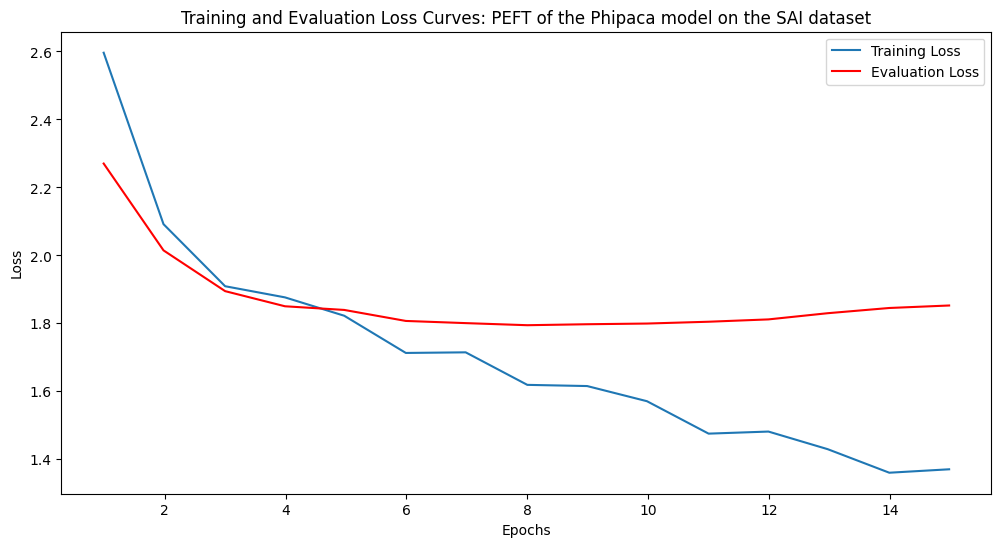

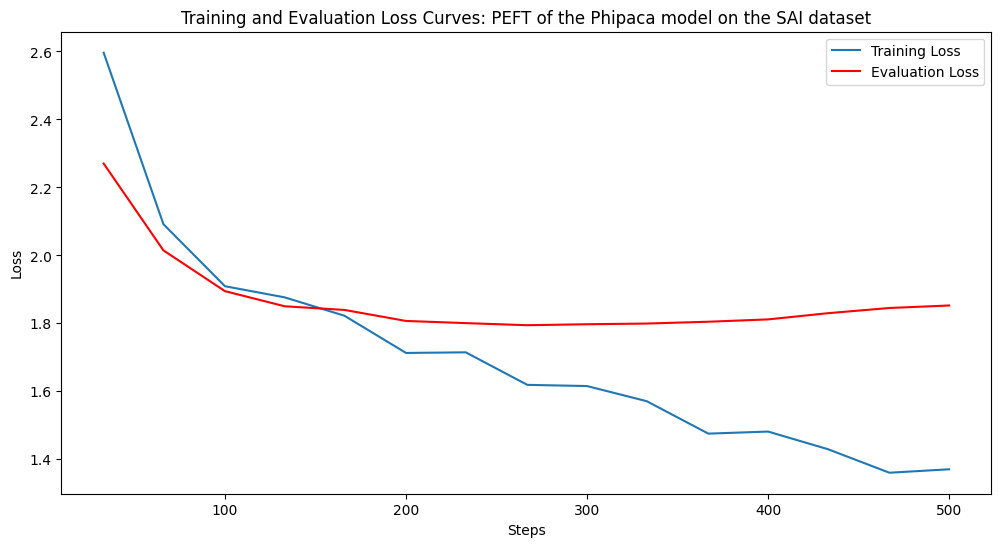

In [24]:
# Extract loss values and steps
training_loss = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
eval_loss = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]
steps = [log['step'] for log in trainer.state.log_history if 'loss' in log]
epochs = [log['epoch'] for log in trainer.state.log_history if 'loss' in log]

######## EPOCHS ########

# Plotting
plt.figure(figsize=(12, 6))

# Plot training loss
plt.plot(epochs, training_loss, label='Training Loss')
eval_epochs = [log['epoch'] for log in trainer.state.log_history if 'eval_loss' in log]
plt.plot(eval_epochs, eval_loss, label='Evaluation Loss', color='red')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss Curves: PEFT of the Phipaca model on the SAI dataset')
plt.legend()

plt.savefig("/content/drive/MyDrive/Colab Notebooks/synthetic_peft/loss_epochs.png")

plt.show()

######## STEPS ########

# Plotting
plt.figure(figsize=(12, 6))

# Since evaluation might occur less frequently, its steps need to be calculated separately
plt.plot(steps, training_loss, label='Training Loss')
eval_steps = [log['step'] for log in trainer.state.log_history if 'eval_loss' in log]
plt.plot(eval_steps, eval_loss, label='Evaluation Loss', color='red')

plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss Curves: PEFT of the Phipaca model on the SAI dataset')
plt.legend()

plt.savefig("/content/drive/MyDrive/Colab Notebooks/synthetic_peft/loss_steps.png")

plt.show()


In [17]:
# Add the adapter to the model
base_model_id = "alekswael/phipaca_instruction"

#Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model_id, use_fast=True, max_length=250)

# Quantization
compute_dtype = getattr(torch, "float16")
bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=compute_dtype,
        bnb_4bit_use_double_quant=True,
)

# Load model
model = AutoModelForCausalLM.from_pretrained(
          base_model_id, trust_remote_code=True, quantization_config=bnb_config, device_map={"": 0}
)

################## SPECIFY THE FINE TUNE CHECKPOINT ######################
adapter = "/content/drive/MyDrive/Colab Notebooks/synthetic_peft/checkpoints/checkpoint-267"
model = PeftModel.from_pretrained(model, adapter)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [18]:
##### HuggingFace credentials #####
from huggingface_hub import notebook_login

notebook_login()

In [19]:
##### PUSH TO HF HUB #####
model.push_to_hub("alekswael/saiphipaca", safe_serialization=True)
tokenizer.push_to_hub("alekswael/saiphipaca")

adapter_model.safetensors:   0%|          | 0.00/18.9M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/alekswael/saiphipaca/commit/b772ab97cc057c2d8590137a473e7c827b5dd978', commit_message='Upload tokenizer', commit_description='', oid='b772ab97cc057c2d8590137a473e7c827b5dd978', pr_url=None, pr_revision=None, pr_num=None)